# Sentiment Analysis: Machine Learning Approach

### Labeling:

In [58]:
import pandas as pd

def review_labeling(data):
    df = pd.read_csv(data, header=None)
    
    # Apply the condition only to the second column (index 1)
    df[1] = df[1].apply(lambda x: 'positive' if x >= 4 else 'neutral' if 3 <= x < 4 else 'negative')
    
    return df

df_processed = review_labeling('Data/ML/NOT.csv')
print(df_processed)

                                                   0         1
0                              This app is not good.  negative
1                 I never had any fun with this app.  negative
2                                            No fun.  negative
3  This was not awesome and I no longer love this...  negative


### Preprocessing:

In [59]:
import numpy as np
import pandas as pd
import spacy
import emoji
import re
import nltk
from tqdm import tqdm
from nltk.sentiment.util import mark_negation


In [60]:
nltk.download('stopwords')
nltk.download('punkt')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Function to map emojis to text. E.g., "Python is 👍" is transformed to "Python is :thumbs_up:"
def map_emojis(text):
    """Convert emojis to their text representations."""
    text = emoji.demojize(text, delimiters=(" ", " "))
    # Replace underscores with spaces in emoji descriptions to avoid them being omitted during tokenization.
    return text.replace('_', ' ')

# Preprocessing function
def preprocess_text(text):
    """Preprocess a single text string."""
    # Lowercase
    text = text.lower()

    # Convert emojis to text
    text = map_emojis(text)

    # Remove URLs and emails
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)

    # Tokenization and Lemmatization using spaCy
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if not token.is_punct and not token.is_stop
    ]
    
    # Apply negation marking
    tokens = mark_negation(tokens)

    return ' '.join(tokens)

tqdm.pandas(desc="Preprocessing Reviews")
df_processed[0] = df_processed[0].progress_apply(preprocess_text)

print(df_processed)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Preprocessing Reviews: 100%|██████████| 4/4 [00:00<00:00, 215.75it/s]

                       0         1
0               app good  negative
1                fun app  negative
2                    fun  negative
3  awesome long love app  negative


### Train/Test Splitting:

In [28]:
from sklearn import model_selection as ms

df_text = df_processed[0]
df_target = df_processed[1]

train_data, test_data, train_target, test_target = ms.train_test_split(df_text, df_target, test_size=0.2, random_state=993, stratify=df_target)

print(test_target)


3158     negative
2683     positive
28634    negative
3523     negative
12701    positive
           ...   
25506     neutral
25621    positive
8370     positive
37       positive
12926    negative
Name: 1, Length: 6000, dtype: object


### Count Vectorizer:

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
train_features = cv.fit_transform(train_data)

print(train_features.shape)

#print(train_features[:3])

(24000, 11638)


In [30]:
from sklearn.preprocessing import Binarizer

transformer = Binarizer()
train_bin = transformer.fit_transform(train_features)
print(train_bin.shape)
print(train_bin[0])

(24000, 11638)
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 7 stored elements and shape (1, 11638)>
  Coords	Values
  (0, 4467)	1
  (0, 934)	1
  (0, 6699)	1
  (0, 544)	1
  (0, 8786)	1
  (0, 8760)	1
  (0, 5640)	1


## Classification Process

Pipeline(steps=[('vect', CountVectorizer(max_df=0.5, min_df=10)),
                ('binarizer', Binarizer()), ('clf', MultinomialNB())])
['negative' 'positive' 'neutral' ... 'positive' 'positive' 'negative']
Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.82      0.76      2144
     neutral       0.25      0.13      0.17       621
    positive       0.86      0.86      0.86      3235

    accuracy                           0.77      6000
   macro avg       0.61      0.60      0.60      6000
weighted avg       0.75      0.77      0.75      6000



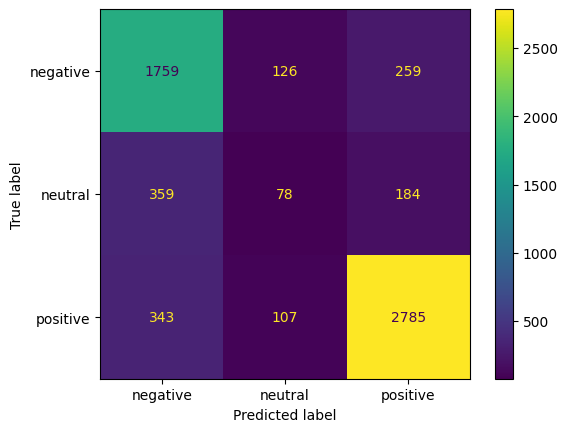

In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

text_clf = Pipeline([('vect', CountVectorizer(min_df=10, max_df=0.5)), 
                     ('binarizer', Binarizer()),
                     ('clf', MultinomialNB()) # Classificiation
                    ])

text_clf.fit(train_data, train_target) 
print(text_clf)
predicted = text_clf.predict(test_data)
print(predicted)

results = pd.DataFrame({
    'Actual': test_target,
    'Predicted': predicted
})


# Confusion Matrix
conf_matrix = confusion_matrix(test_target, predicted)
print("Confusion Matrix:")

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=text_clf.classes_)
disp.plot()

# Classification Report
report = classification_report(test_target, predicted, target_names=text_clf.classes_)
print("Classification Report:")
print(report)